In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.style.use("seaborn-v0_8-darkgrid")
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Preparing the data

Let's get some data in here.

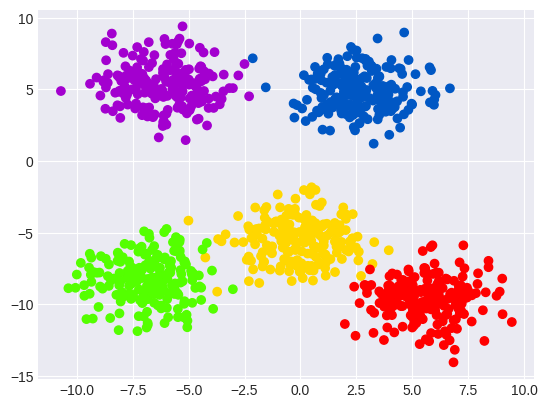

In [10]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=1000, centers=5, cluster_std=1.5, random_state=10)

plt.style.use("seaborn-v0_8-darkgrid")
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap="prism")
plt.show()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## Base model

Let's try a linear neural network

In [4]:
class BlobsModelV0(nn.Module):
    def __init__(self, in_shape, hidden_units, out_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=out_shape),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.layer_stack.forward(X)

model = BlobsModelV0(
    in_shape=2, hidden_units=16, out_shape=5
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1.5)

In [5]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    y_logits = model.forward(X_train)
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 1.5927637815475464
Epoch: 100 | Loss: 1.0634254217147827
Epoch: 200 | Loss: 1.0034157037734985
Epoch: 300 | Loss: 1.0017364025115967
Epoch: 400 | Loss: 1.0009247064590454
Epoch: 500 | Loss: 1.0004513263702393
Epoch: 600 | Loss: 1.0001498460769653
Epoch: 700 | Loss: 0.9999410510063171
Epoch: 800 | Loss: 0.999786376953125
Epoch: 900 | Loss: 0.9996665120124817


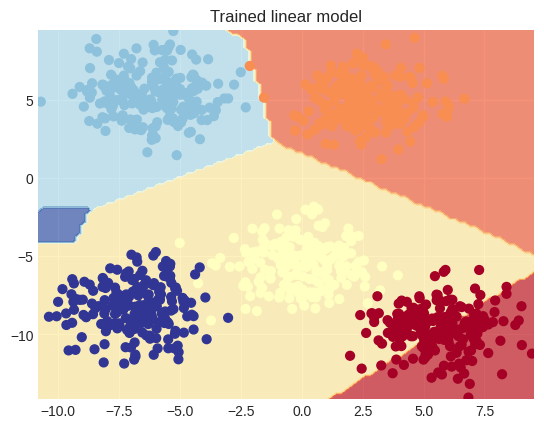

In [6]:
plt.title("Trained linear model")
plot_decision_boundary(model, X, y)

## Non-linear model

Well... the linear model sucks to say the least. Let's add some activation functions.

A linear model would be enough, with some experimentation I am sure we can easily match the dataset.

In [7]:
class BlobsModelV0(nn.Module):
    def __init__(self, in_shape, hidden_units, out_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Softplus(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_shape),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.layer_stack.forward(X)

model = BlobsModelV0(
    in_shape=2, hidden_units=32, out_shape=5
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1.5)

In [8]:
epochs = 5000

for epoch in range(epochs):
    model.train()
    y_logits = model.forward(X_train)
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 1.617354393005371
Epoch: 1000 | Loss: 0.9083738923072815
Epoch: 2000 | Loss: 0.9080914855003357
Epoch: 3000 | Loss: 0.9066470265388489
Epoch: 4000 | Loss: 0.906523585319519


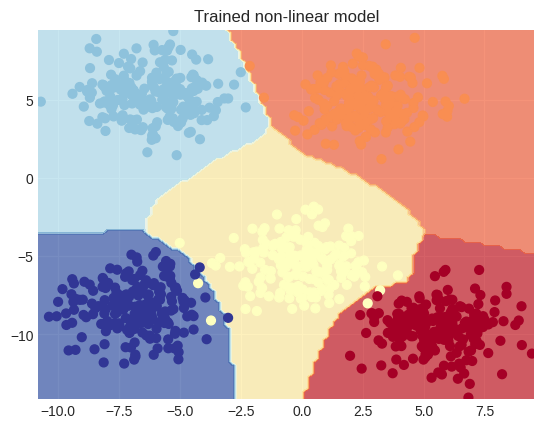

In [9]:
plt.title("Trained non-linear model")
plot_decision_boundary(model, X, y)